In [2]:
from pyroutelib3 import Router # Import the router
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import utm
router = Router("car","./map_new.osm") # Initialise it

In [3]:
connection = list(router.routing.items())
result_from = []
result_to = []
for j in range(len(connection)):
    id, data = connection[j]
    orig = router.nodeLatLon(id)
    uorig = utm.from_latlon(list(orig)[0],list(orig)[1])
    data = list(data)
    for i in range(len(data)):
        candi = router.nodeLatLon(data[i])
        ucandi = utm.from_latlon(list(candi)[0],list(candi)[1])
        result_from.append(uorig)
        result_to.append(ucandi)

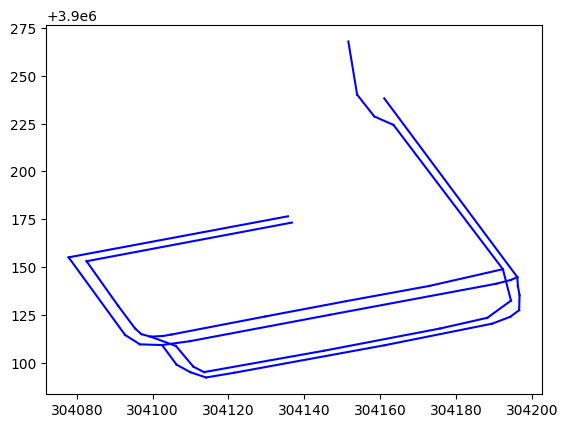

In [4]:
plt.figure(0)
plt.clf()
for i in range(len(result_from)):
    x_value = [result_from[i][0], result_to[i][0]]
    y_value = [result_from[i][1], result_to[i][1]]
    plt.plot(x_value, y_value, 'b-')

In [5]:
rnode = list(router.rnodes.items())
route_id = []
route_pointx = []
route_pointy = []
route_utmx = []
route_utmy = []
for i in range(len(rnode)):
    id ,(x,y) = rnode[i]
    route_id.append(id)
    route_pointx.append(y)
    route_pointy.append(x)
    utm_data = utm.from_latlon(x, y)
    route_utmx.append(utm_data[0])
    route_utmy.append(utm_data[1])

In [6]:
start = router.findNode(35.2255306, 126.847828) # Find start and end nodes
end = router.findNode(35.225225, 126.848449)

#end = router.findNode(35.22635, 126.84801) # Find start and end nodes
#start = router.findNode(35.22571, 126.84777)

In [7]:
status, route = router.doRoute(start, end) # Find the route - a list of OSM nodes
if status == 'success':
    print('Success')
    routeLatLons = list(map(router.nodeLatLon, route)) # Get actual route coordinates
else:
    print('Fail')
print(routeLatLons)

Success
[(35.22553171452, 126.84782937035), (35.22532684975, 126.84719905123), (35.2249642269, 126.84737205371), (35.22492040529, 126.84741631016), (35.22491821421, 126.84748068318), (35.22493793394, 126.84756114945), (35.22506939865, 126.84796281025), (35.22522441718, 126.84844091401)]


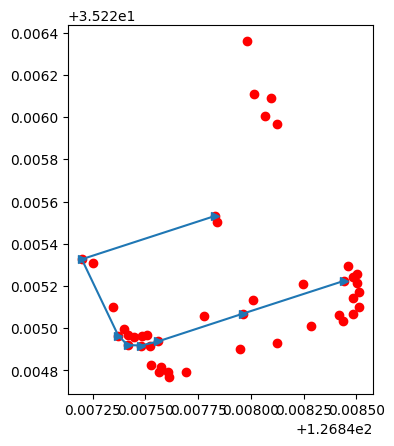

In [8]:
img_pointx = []
img_pointy = []
utm_pointx = []
utm_pointy = []
for x,y in routeLatLons:
    img_pointx.append(y)
    img_pointy.append(x)
    utm_data = utm.from_latlon(x,y)
    utm_pointx.append(utm_data[0])
    utm_pointy.append(utm_data[1])

plt.figure(3)
plt.clf()
plt.axes().set_aspect('equal')
plt.scatter(route_pointx,route_pointy,color = 'red')
plt.plot(img_pointx,img_pointy,marker=">")


In [9]:
from pypcd4 import PointCloud
pc: PointCloud = PointCloud.from_path("trans_new.pcd")
array: np.ndarray = pc.numpy()
array.shape

down_array = array[::10,:]
%matplotlib tk
plt.figure(1)
plt.clf()
#scatter marker size
plt.scatter(down_array[:,0],down_array[:,1],color='g',s=1)
plt.gca().set_aspect('equal', adjustable='box')           

In [25]:
import math
start = utm.from_latlon(35.22635, 126.84801)
end = utm.from_latlon(35.22571, 126.84777)
x_mean = array[:,0].mean()
y_mean = array[:,1].mean()
z_mean = array[:,2].mean()
nrray = np.zeros((array.shape[0],3))
nrray[:,0] = array[:,0] - x_mean 
nrray[:,1] = array[:,1] - y_mean 
nrray[:,2] = array[:,2] - z_mean
theta = math.radians(3)
nrray[:,0] = nrray[:,0]*math.cos(theta) - nrray[:,1]*math.sin(theta)
nrray[:,1] = nrray[:,0]*math.sin(theta) + nrray[:,1]*math.cos(theta)

nrray[:,0] = nrray[:,0] + end[0]+12
nrray[:,1] = nrray[:,1] + end[1]-80
dn_array = nrray[::10,:]
%matplotlib tk
plt.figure(2)
plt.clf()
#scatter marker size
plt.scatter(dn_array[:,0],dn_array[:,1],color='g',s=0.5)
plt.scatter(start[0],start[1],color='r',s=100)
plt.scatter(end[0], end[1],color='r',s=100)
plt.scatter(route_utmx,route_utmy,color = 'red')

for i in range(len(result_from)):
    x_value = [result_from[i][0], result_to[i][0]]
    y_value = [result_from[i][1], result_to[i][1]]
    plt.plot(x_value, y_value, 'b-')

plt.plot(utm_pointx,utm_pointy,marker=">",color='red')
plt.xlim(304000,304300)
plt.ylim(50+3.9e6,200+3.9e6)

plt.gca().set_aspect('equal', adjustable='box')   

In [11]:
def route_interpolation(route_utmx,route_utmy,length):
    route_x = []
    route_y = []
    for i in range(len(route_utmx)-1):
        x = route_utmx[i]
        y = route_utmy[i]

        dx = route_utmx[i+1] - route_utmx[i]
        dy = route_utmy[i+1] - route_utmy[i]

        if math.sqrt(dx**2+dy**2) > length:
            n = math.floor(math.sqrt(dx**2+dy**2)/length)
            dx = dx/n
            dy = dy/n
            for j in range(n):
                route_x.append(x+dx*(j+1))
                route_y.append(y+dy*(j+1))
    return route_x,route_y

route_x,route_y = route_interpolation(utm_pointx,utm_pointy,1)

plt.figure(4)
plt.clf()
plt.scatter(route_x,route_y,color = 'red')
plt.scatter(utm_pointx[0],utm_pointy[0],color = 'blue',s=100)
plt.xlim(304000,304300)
plt.ylim(50+3.9e6,200+3.9e6)
plt.gca().set_aspect('equal', adjustable='box') 

In [12]:
# Parameters
k = 0.1  # look forward gain
Lfc = 5.0  # [m] look-ahead distance
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time tick
WB = 2.9  # [m] wheel base of vehicle

class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.rear_x = self.x - ((WB / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((WB / 2) * math.sin(self.yaw))

    def update(self, a, delta):
        self.x += self.v * math.cos(self.yaw) * dt
        self.y += self.v * math.sin(self.yaw) * dt
        self.yaw += self.v / WB * math.tan(delta) * dt
        self.v += a * dt
        self.rear_x = self.x - ((WB / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((WB / 2) * math.sin(self.yaw))

    def calc_distance(self, point_x, point_y):
        dx = self.rear_x - point_x
        dy = self.rear_y - point_y
        return math.hypot(dx, dy)
class States:

    def __init__(self):
        self.x = []
        self.y = []
        self.yaw = []
        self.v = []
        self.t = []

    def append(self, t, state):
        self.x.append(state.x)
        self.y.append(state.y)
        self.yaw.append(state.yaw)
        self.v.append(state.v)
        self.t.append(t)

class TargetCourse:

    def __init__(self, cx, cy):
        self.cx = cx
        self.cy = cy
        self.old_nearest_point_index = None

    def search_target_index(self, state):

        # To speed up nearest point search, doing it at only first time.
        if self.old_nearest_point_index is None:
            # search nearest point index
            dx = [state.rear_x - icx for icx in self.cx]
            dy = [state.rear_y - icy for icy in self.cy]
            d = np.hypot(dx, dy)
            ind = np.argmin(d)
            self.old_nearest_point_index = ind
        else:
            ind = self.old_nearest_point_index
            distance_this_index = state.calc_distance(self.cx[ind],
                                                      self.cy[ind])
            while True:
                distance_next_index = state.calc_distance(self.cx[ind + 1],
                                                          self.cy[ind + 1])
                if distance_this_index < distance_next_index:
                    break
                ind = ind + 1 if (ind + 1) < len(self.cx) else ind
                distance_this_index = distance_next_index
            self.old_nearest_point_index = ind

        Lf = k * state.v + Lfc  # update look ahead distance

        # search look ahead target point index
        while Lf > state.calc_distance(self.cx[ind], self.cy[ind]):
            if (ind + 1) >= len(self.cx):
                break  # not exceed goal
            ind += 1

        return ind, Lf
def proportional_control(target, current):
    a = Kp * (target - current)

    return a

def pure_pursuit_steer_control(state, trajectory, pind):
    ind, Lf = trajectory.search_target_index(state)

    if pind >= ind:
        ind = pind

    if ind < len(trajectory.cx):
        tx = trajectory.cx[ind]
        ty = trajectory.cy[ind]
    else:  # toward goal
        tx = trajectory.cx[-1]
        ty = trajectory.cy[-1]
        ind = len(trajectory.cx) - 1

    alpha = math.atan2(ty - state.rear_y, tx - state.rear_x) - state.yaw

    delta = math.atan2(2.0 * WB * math.sin(alpha) / Lf, 1.0)

    return delta, ind

def plot_arrow(x, y, yaw, length=3.0, width=2, fc="r", ec="k"):
    """
    Plot arrow
    """

    if not isinstance(x, float):
        for ix, iy, iyaw in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)

target_speed = 10.0 / 3.6  # [m/s]
T = 100.0  # max simulation time
state = State(x=utm_pointx[0], y=utm_pointy[0], yaw=3.5, v=0.0)
lastIndex = len(route_x) - 1
time = 0.0
states = States()
states.append(time, state)
target_course = TargetCourse(route_x, route_y)
target_ind, _ = target_course.search_target_index(state)

while T >= time and lastIndex > target_ind:
        # Calc control input
        ai = proportional_control(target_speed, state.v)
        di, target_ind = pure_pursuit_steer_control(
            state, target_course, target_ind)

        state.update(ai, di)  # Control vehicle

        time += dt
        states.append(time, state)

        plt.cla()
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        plot_arrow(state.x, state.y, state.yaw)
        plt.plot(utm_pointx[0],utm_pointy[0],"xb", label="start")
        plt.plot(route_x, route_y, "-r", label="course")
        plt.plot(states.x, states.y, "-b", label="trajectory")
        plt.plot(route_x[target_ind], route_y[target_ind], "xg", label="target")
        plt.axis("equal")
        plt.grid(True)
        plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
        plt.pause(0.001)

In [14]:
#save pcd
pc = PointCloud.from_xyz_points(nrray)
pc.save("nice_point_cloud.pcd")

In [26]:
# 사무실로부터의 상대좌표계 설정
# 내 사무실의 조표계
# lon : 35.2248385
# lat : 126.8472487
lon = 35.2248385
lat = 126.8472487
samusil = utm.from_latlon(lon, lat)
# 이후 nrray 를 snrray 로 변경 
# 이때, nrray는 이미 utm 좌표계로 설정이 되어있음
snrray = np.zeros((nrray.shape[0], nrray.shape[1]))
for i in range(nrray.shape[0]):
        snrray[i, 0] = nrray[i, 0] - samusil[0]
        snrray[i, 1] = nrray[i, 1] - samusil[1]
        snrray[i, 2] = nrray[i, 2]

#save pcd
pc = PointCloud.from_xyz_points(snrray)
pc.save("samu_cloud.pcd")


In [27]:
samusil

(304081.18053647294, 3900100.7654250246, 52, 'S')